#  Прогнозирование заказов такси

**Цель работы**: на основе данных о прошлых заказах такси создать модель, предсказывающую количество заказов на следующий час со значеием метрики качества RMSE <46.


In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


## Подготовка данных

In [2]:
data = pd.read_csv('/datasets/taxi.csv',
                   index_col=[0], parse_dates=[0] )

display(data.head())
data.info()
data.describe()





Проверка на монотонность индекса даты-времени:

In [3]:
print(data.index.is_monotonic)




### Вывод
Индекс монотоннен, пропусков нет, можно начать анализ данных  и дальнейшее разделение на выборки

Выполняем ресемплирование:

In [4]:
print(type(data))
print(len(data))

data = data.resample('1H').sum()

print(type(data))
print(len(data))



In [5]:
display(data['num_orders'])
print(min(data['num_orders']))

## Анализ данных

Всего 4416 часов, это 184 суток и примерно 6 месяцев. Посмотрим гистограмму, медиану и среднее всех данных, за месяц и день. 

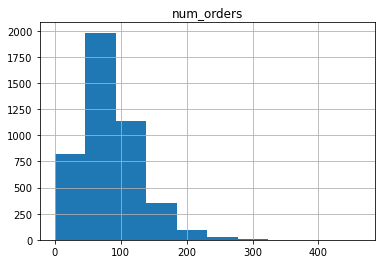

In [6]:
data.hist()

print('Среднее арифметическое за все время' , data['num_orders'].mean())
print('Медиана за все время', data['num_orders'].median())


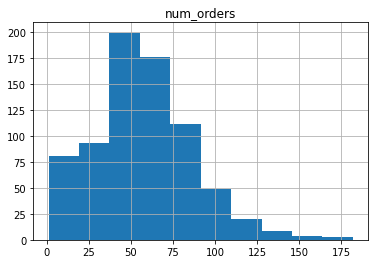

In [7]:
data_month = data['2018-03-01':'2018-03-31']
data_month.hist()

In [8]:
print('Среднее арифметическое за март', data_month['num_orders'].mean())
print('Медиана за март', data_month['num_orders'].median())

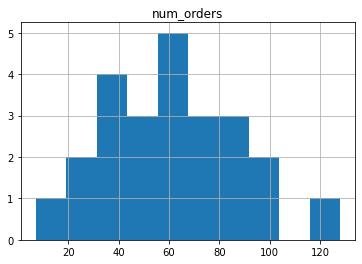

In [9]:
data_day = data['2018-03-31']
data_day.hist()

In [10]:
print('Среднее арифметическое за 31 марта', data_day['num_orders'].mean())
print('Медиана за 31 марта', data_day['num_orders'].median())

In [11]:
decomposed = seasonal_decompose(data)

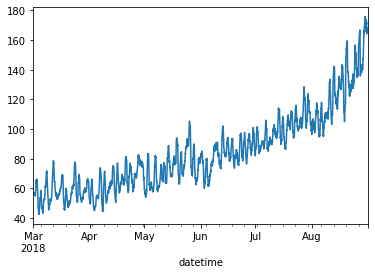

In [12]:
decomposed.trend.plot(ax = plt.gca())

Тренд показывает рост, и изменение стандартного отклонения, поэтому он не является стационарным. 


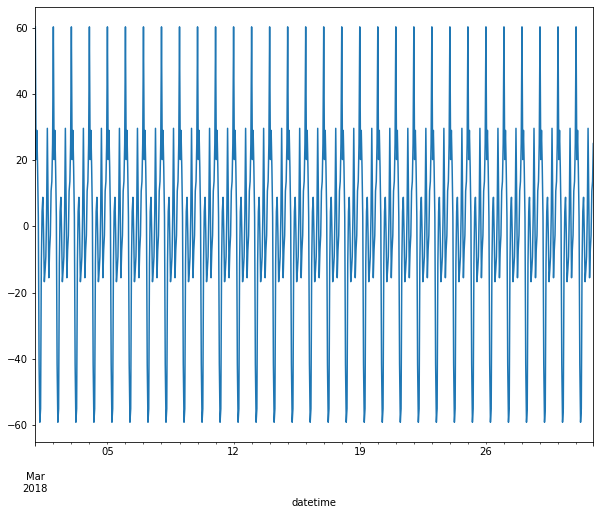

In [13]:
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax = plt.gca(), figsize=(10,8))

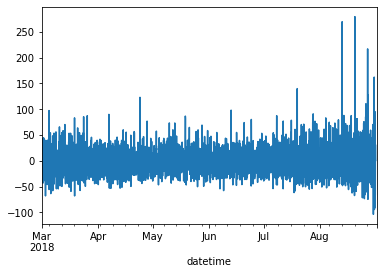

In [14]:
decomposed.resid.plot(ax = plt.gca())

## Обучение модели

Дополним данные признаками: календарными, остающими и скользящим средним

Календарные (месяц, день недели, час, год добавлять бессмысленно - он у нас один):

In [15]:
#data['month'] = data.index.month
#data['day'] = data.index.day

In [16]:
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
display(data.head())

Отстающие:

In [17]:
def lag_features(data, max_lag, rolling_mean_size):    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()



In [18]:
#попробуем с такими значениями, в дальнейшем, возможно, придется экспериментально подобрать другие

lag_features(data, 2, 10)

In [19]:
display(data.head(20))

In [20]:
#удаляем пропущенные значения

data.dropna(inplace=True)

In [21]:
data.head()

Разобьем данные на тренировочную, валидационную и тестовую в соотношении 80:10:10

In [22]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)

In [23]:
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)



In [24]:
print(len(train), len(valid), len(test))

In [25]:
train.index.is_monotonic

In [26]:
valid.index.is_monotonic

In [27]:
test.index.is_monotonic

In [28]:
train.tail()

In [29]:
valid.head()

In [30]:
valid.tail()

In [31]:
test.head()

Разбитие на выборки прошло корректно

In [32]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

In [33]:
valid_features = valid.drop('num_orders', axis=1)
valid_target = valid['num_orders']

In [34]:
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Начнем тестировать модели: попробуем линейную регрессию, случайный лес 

In [35]:
def best_model(model):
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    
    score = mean_squared_error(valid_target, predictions)**0.5
    print('Модель:', model,'Значение метрики RMSE:', score)

In [36]:
model_LR = LinearRegression()

In [37]:
best_model(model_LR)

Начнем подбирать гиперпараметры для Случайного леса:

In [38]:
#depths={}


#for depth in range(3,100):

#    model = RandomForestRegressor(n_jobs=-1, max_depth=depth,)
#    model.fit(train_features, train_target)
#    predictions = model.predict(valid_features)
    
#    score = mean_squared_error(valid_target, predictions)**0.5
#    depths.update({depth:score})


In [40]:
#best_depth = min(depths, key = depths.get)
#print(best_depth)

Лучшая глубина = 15

In [ ]:
#n_estimators_dict = {}

#for n_estimator in range(7,200):
#    model = RandomForestRegressor(n_jobs=-1, max_depth=15, n_estimators=n_estimator)
#    
#    model.fit(train_features, train_target)
#    predictions = model.predict(valid_features)
#    
#    score = mean_squared_error(valid_target, predictions)**0.5
#    n_estimators_dict.update({n_estimator:score})

In [ ]:
#best_number_of_estimators = min(n_estimators_dict, key = n_estimators_dict.get)
#print(best_number_of_estimators)

best_number_of_estimators = 24

In [ ]:
#leaves = {}

#for min_leaves in range(2,20):
#    model = RandomForestRegressor(n_jobs=-1, max_depth=15, n_estimators=24, min_samples_split = min_leaves)
    
#    model.fit(train_features, train_target)
#    predictions = model.predict(valid_features)
    
#    score = mean_squared_error(valid_target, predictions)**0.5
#    leaves.update({min_leaves:score})

In [ ]:
#best_split_number = min(leaves, key = leaves.get)
#print(best_split_number)

best_split_number = 7

Обучим модель на обоих выборках: и на тренировочной и н авалидационной, возможно, это поможет улучшить результат. 

In [41]:
train_valid_features = train_valid.drop('num_orders', axis=1)

In [42]:
train_valid_target = train_valid['num_orders']

In [51]:
depths={}


for depth in range(3,100):

    model = RandomForestRegressor(n_jobs=-1, max_depth=depth,)
    model.fit(train_valid_features, train_valid_target)
    predictions = model.predict(valid_features)
    
    score = mean_squared_error(valid_target, predictions)**0.5
    depths.update({depth:score})



In [52]:
best_depth = min(depths, key = depths.get)
print(best_depth)

In [60]:
n_estimators_dict = {}

for n_estimator in range(7,200):
    model = RandomForestRegressor(n_jobs=-1, max_depth=40, n_estimators=n_estimator)
    
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    
    score = mean_squared_error(valid_target, predictions)**0.5
    n_estimators_dict.update({n_estimator:score})

In [54]:
best_number_of_estimators = min(n_estimators_dict, key = n_estimators_dict.get)
print(best_number_of_estimators)

In [61]:
leaves = {}

for min_leaves in range(2,20):
    model = RandomForestRegressor(n_jobs=-1, max_depth=40, n_estimators=best_number_of_estimators, min_samples_split = min_leaves)
    
    model.fit(train_features, train_target)
    predictions = model.predict(valid_features)
    
    score = mean_squared_error(valid_target, predictions)**0.5
    leaves.update({min_leaves:score})

In [62]:
best_split_number = min(leaves, key = leaves.get)
print(best_split_number)

In [69]:
model_RF = RandomForestRegressor(n_jobs=-1, n_estimators = best_number_of_estimators, max_depth = best_depth,
                                 min_samples_split = best_split_number)

model_RF.fit(train_valid_features, train_valid_target)

predictions = model_RF.predict(test_features)

score = mean_squared_error(test_target, predictions)**0.5


print(score)



## Тестирование

Проверим модель на вменяемость - создадим дамми-модель, которая будет выдавать медиану и посчитаем значение RMSE для такой "модели".

In [49]:
dummy_predictions = np.ones(test_target.shape) * train_target.median()

print("RMSE дамми-модели на тестовой выборке:", mean_squared_error(test_target, dummy_predictions)**0.5)


Наша модель прошла проверку на адекватность. 

## Графики

In [81]:
predictions_df = pd.DataFrame(predictions, index= test_target.index)

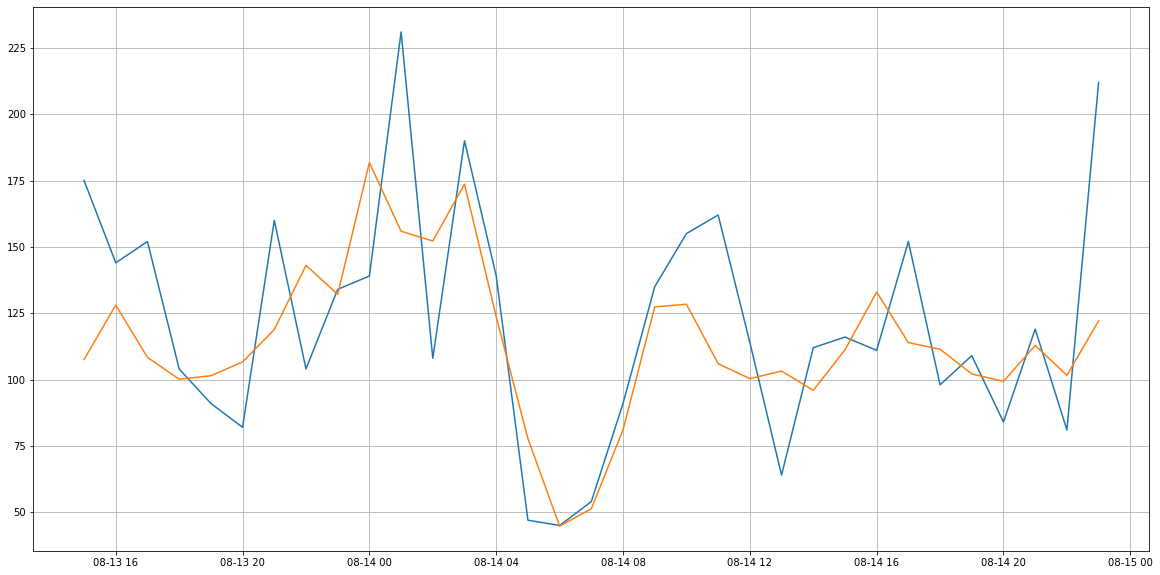

In [99]:
fig, ax = plt.subplots()

ax.plot(test_target['2018-08-13':'2018-08-14'])

ax.plot(predictions_df['2018-08-13':'2018-08-14'])

fig.set_size_inches(20,10)

ax.grid(True)

#test_target.plot(figsize=(15,10))
plt.show()



## Вывод

Данные были загружены, произведен респемплинг, также данные были проанализированы, дополнительные признаки подготовлены, а итоговая модель с подобранными гиперпараметрами показала значение RMSE менее 48. 